# Facial Keypoints Detection
## Deep Learning Project by Sang-Ha Park
https://www.kaggle.com/c/facial-keypoints-detection

## Table of Contents
### [1. Data Exploration](#1)

### [2. Problem Approach](#2)

### [3. CNN Modelling](#3)
  * [Dimensionality of Output](#3.1)
  * [Kernel Size](#3.2)
  * [Kernel Initialization](#3.3)
  * [Batch Normalization](#3.4)
  * [Activation Function](#3.5)
  * [Regularization](#3.6)
  
### [4. Learning Method: Gradient Descent Optimization](#4)

### [5. Training](#5)
  * [Cost Function](#5.1)
  * [Mini-batch Training](#5.2)
  * [Callbacks at the End of Each Batch](#5.3)
  * [Batch Generator & Training-time Data Augmentation](#5.4)
  
### [6. More on Model Optimization](#6)
  * [Best Single CNN Model vs. Ensemble Model](#6.1)
  * [Face Detection with OpenCV](#6.2)
  * [Advanced Image Augmentation](#6.3)
  
### [7. Final Kaggle Submission](#7)
  * [Final Score](#7.1)
  

In [23]:
%matplotlib inline
from K.utils.utils import *
import pandas as pd

<a id="1"></a>
# 1. Data Exploration

In [2]:
df = pd.read_csv('./data/training.csv')

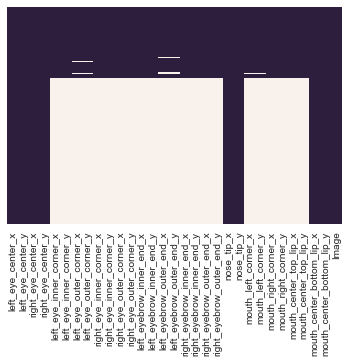

In [3]:
sns.heatmap(df.isnull() == False, cbar=False, yticklabels=False)

The entire dataset is drawn as a heat map and the white part is where the data is missing. For some of the keypoints we have only about 2000 labels, while other keypoints have more than 7000 labels available for training.

In [4]:
df.head(1)

left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0          66.033564          39.002274           30.227008   

   right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0           36.421678                59.582075                39.647423   

   left_eye_outer_corner_x  left_eye_outer_corner_y  right_eye_inner_corner_x  \
0                73.130346                39.969997                 36.356571   

   right_eye_inner_corner_y  \
0                 37.389402   

                         ...                          nose_tip_y  \
0                        ...                           57.066803   

   mouth_left_corner_x  mouth_left_corner_y  mouth_right_corner_x  \
0            61.195308            79.970165             28.614496   

   mouth_right_corner_y  mouth_center_top_lip_x  mouth_center_top_lip_y  \
0             77.388992               43.312602               72.935459   

   mouth_center_bottom_lip_x  mouth_center_bottom_lip_y  \
0                  43.130707                  84.485774   

                                               Image  
0  238 236 237 238 240 240 239 241 241 243 240 23...  

[1 rows x 31 columns]

15 facial keypoints are given in x-y coordinates. The last column, Image, is the data, a gray-scale image of 96x96x1 size. Let's visualize a subset of the training data.

In [5]:
X_train, _, Y_train, _ = load_train_data_and_split("data/training.csv", COLS, 0.1)

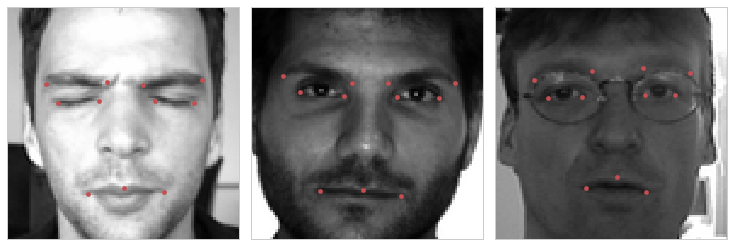

In [6]:
import matplotlib.pyplot as plt
def plot_data(img, landmarks, axis):
    axis.imshow(np.squeeze(img), cmap='gray')
    landmarks = landmarks * 48 + 48
    axis.scatter(landmarks[0::2], landmarks[1::2], marker='o', c='r', s=20)
    
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(3):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    plot_data(X_train[i], Y_train[i], ax)

<a id="2"></a>
# 2. Problem Approach

A total of 30 correct position (the x and y coordinates) of 15 facial keypoints must be predicted. Instead of dropping images with partial labels, I decided to train the CNN model separately by dividing the dataset into two. The size of dataset with 4 keypoints is much smaller than the dataset with 11 keypoints. I will handle this problem with data augmentation.
<br>
### Splitting Dataset
* Dataset 1 with 4 Keypoints
  * left_eye_center
  * right_eye_center
  * nose_tip
  * mouth_center_bottomlip
* Dataset 2 with 11 Keypoints
  * left_eye_inner_corner
  * left_eye_outer_corner
  * right_eye_inner_corner
  * right_eye_outer_corner
  * left_eyebrow_inner_corner
  * left_eyebrow_outer_corner
  * right_eyebrow_inner_corner
  * right_eyebrow_outer_corner
  * mouth_left
  * mouth_right
  * mouth_center
<br>

### Pre-processing
I will also use OpenCV for pre-processing and face detection. OpenCV will detect the face and the trained CNN model will predict the facial keypoints within that location. The more data there is, the less overfitting can be achieved. Using OpenCV, images will be augmented during training before every batch. This allows training with unlimited data.

### Training
I decided to use <strong>mean squared error</strong> as the cost function because this is a non-linear regression problem. For a learning method, there are several options such as stochastic gradient descent, adagrad, and RMSProp. All methods will be tested and I will see which one works the best.

### Testing
I will predict the test data and upload it to kaggle to see how competitive my model is.

<a id="3"></a>
# 3. CNN  Modelling

I have applied various CNN architectures for fast error convergence time and cost function minimization. However, the deeper the layers, the longer the training took. Despite having more parameters that can be trained
MSE did not decrease significantly, but rather worse.
I had to test the model multiple times, changing the hyper parameters. If the cost function converges quickly and MSEs are similar, I have chosen a simpler architecture.

<table>
    <tr>
        <!--<td><img src="img/cnn_model.png" width=300 /></td> -->
        <td><img src="img/summary.png" width=500/></td>
    </tr>
</table>


<a id="3.1"></a>
* ### Dimensionality of Output
  * As convolution layers deepen, the number of kernels increases like 24 → 36 → 48 → 64 
  
<a id="3.2"></a>
* ### Kernel Size
  * 3x3 vs 5x5
  * Small filter sizes captures fine details of the image and a bigger filter size leaves out minute details in the image.
  * I chose filter size 5 because it is a fairly simple problem compared to other image classification problems.

<a id="3.3"></a>
* ### Kernel Initialization
  * The initial value of the kernel has a very large effect on the training speed and convergence, so I used the He Normal, which is the most recently used.
  * He Normal
    * $ \text{Truncated Normal}(0, \sqrt{\text{# of input units}}) $

<a id="3.4"></a>
* ### Batch Normalization
  * To precent gradient vanishing and exploding
  * Since the output value is normalized for each learning, it is less influenced by the initialization.

<a id="3.5"></a>
* ### Activation Function
  * Rectified Linear Units (ReLU): $\max(0,Wx+b)$
  * To avoid gradient vanishing, I used ReLU over sigmoid for the activation function.

<a id="3.6"></a>
* ### Regularization
  * Lasso(L1) & Ridge(L2)
  * Dropout
  * <strong>No Regularizations</strong>
    * During training, data augmentation is applied to every mini-batch, so it will train based on randomly augmented set of data. I do not apply normalization because I judged that it is unlikely to overfit.

<a id="4"></a>
# 4. Learning Method: Gradient Descent Optimization

* Stochastic Gradient Descent
$$
\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta)
$$

* Adagrad
$$
G_t \leftarrow G_{t-1} + (\nabla_{\theta}J(\theta_t))^2
$$

$$
\theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{G_t+\epsilon}}\cdot \nabla_{\theta}J(\theta_t)
$$

* RMSProp
$$
G_t \leftarrow \gamma{G_{t-1}} + (1-\gamma)(\nabla_{\theta}J(\theta_t))^2
$$

$$
\theta_{t+1} \leftarrow \theta_t - \frac{\eta}{\sqrt{G_t+\epsilon}}\cdot \nabla_{\theta}J(\theta_t)
$$

<img src="img/opts.gif" width=350/>
Ref: http://i.imgur.com/2dKCQHh.gif?1

It is difficult to say which optimization method is the best. The performance of each method varies depending on the problem, data set, and network structure. In my case, <strong>RMSProp</strong> showed the best performance.

<a id="5"></a>
# 5. Training

<a id="5.1"></a>
### Cost Function
  * Mean Squared Error
$$
    \text{MSE} = \frac{1}{n}\sum^{n}_{i=1}{(Y_i - \hat{Y}_i)^2}
$$

<a id="5.2"></a>
### Mini-Batch Training
  * Dataset 1
    * N = 7000
    * Batch Size = 256
  * Dataset 2
    * N = 2155
    * Batch Size = 128

<a id="5.3"></a>
### Callbacks at the End of Each Batch
  * ModelCheckpoint
    * Stored weight values for every epoch
    * During training on AWS spot instance, the instance can be terminated without notice. I have to save the parameter values that were previously trained to start again.
  * EarlyStopping
    * If there is no performance improvement over the last 50 epochs, training is automatically stopped.

<a id="5.4"></a>
### Batch Generator & Real-time Data Augmentation
  * The image data is newly augmented for each batch.
  * Pros and Cons
    * Pros: Image data that can be augmented in an infinite way. This is good to avoid overfitting.
    * Cons: It slows down the training by augmenting images every batch.
  * Image Augmentation
    * Horizontal Flip
    * Contrast
    * Rotation
$$
    \text{Transforming Matrix of Counter-clockwise Rotation}
$$
<br>
$$
\begin{bmatrix} 
x^{'} \\
y^{'} 
\end{bmatrix}
=
\begin{bmatrix} 
\cos{\theta} & -\sin{\theta} \\
\sin{\theta} & \cos{\theta} 
\end{bmatrix}
\begin{bmatrix} 
x \\
y 
\end{bmatrix}
$$

In [7]:
X_train, _, Y_train, _ = load_train_data_and_split("data/training.csv", COLS, 0.1)

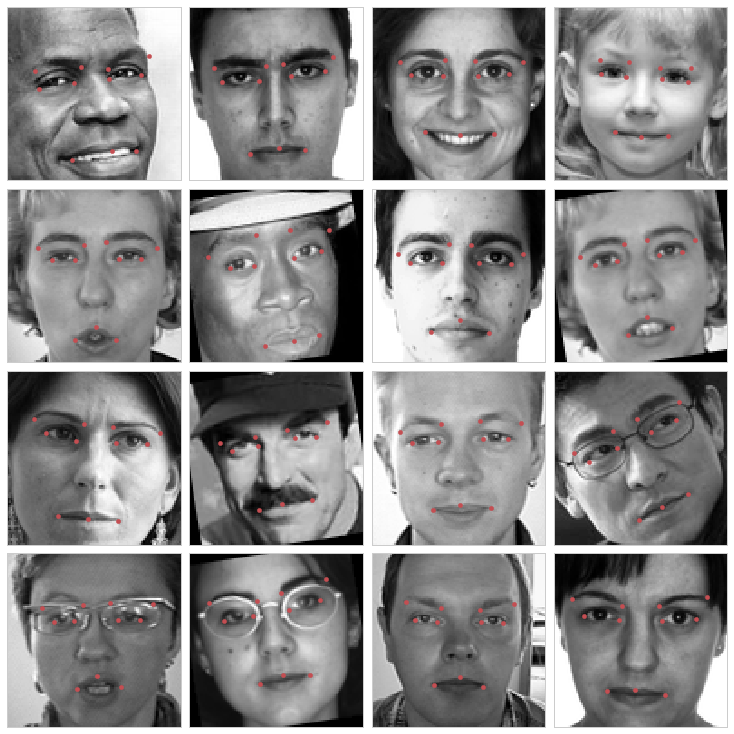

In [8]:
generate_augmented_images(X_train, Y_train, True, True, True, False, False)

<a id="6"></a>
# 6. More on Model Optimization

<a id="6.1"></a>
## Best Single CNN Model vs. Ensemble
* Not all models produce the same error for given test data.
* Let's reduce generalization error through model averaging.

### Ensemble

In [9]:
model_name = 'model_20171117_1723'
X_test = load_test_data('./data/test.csv')

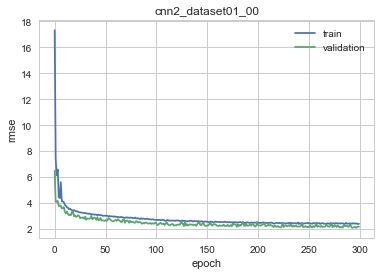

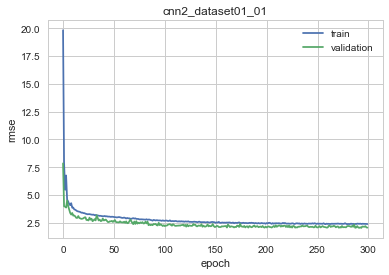

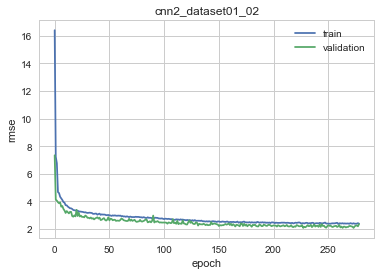

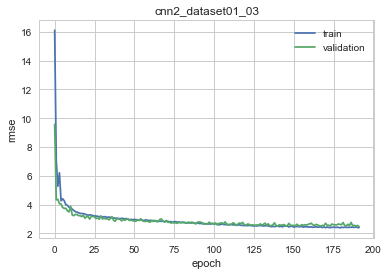

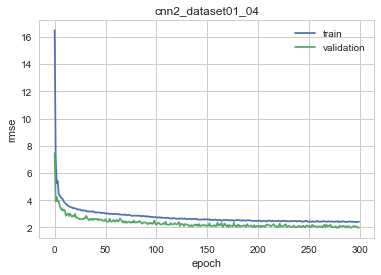

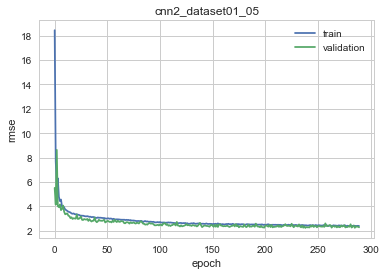

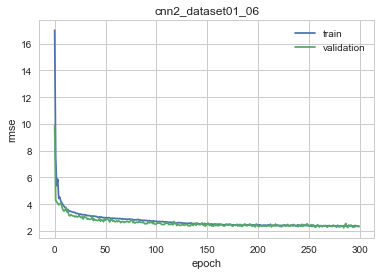

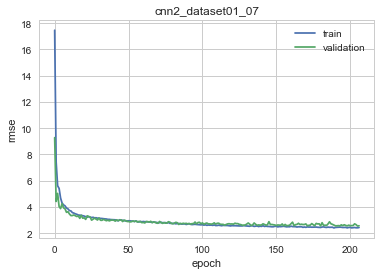

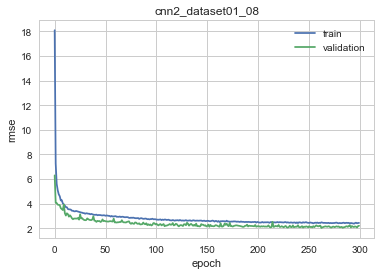

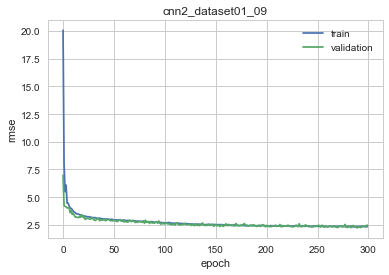

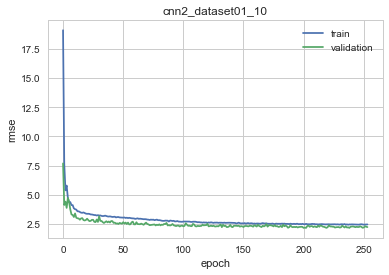

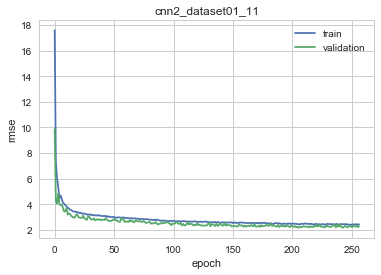

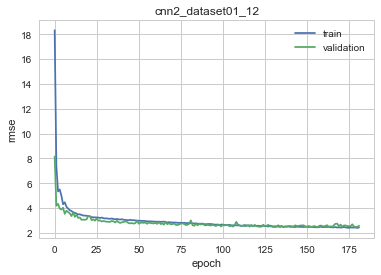

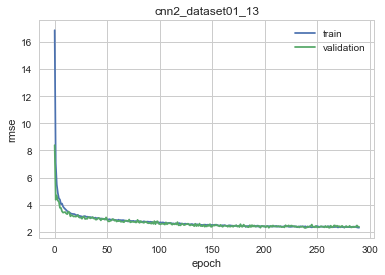

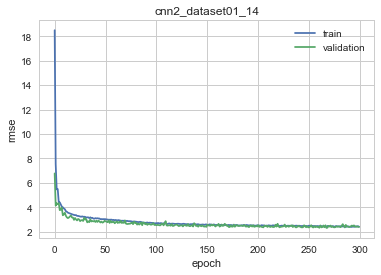

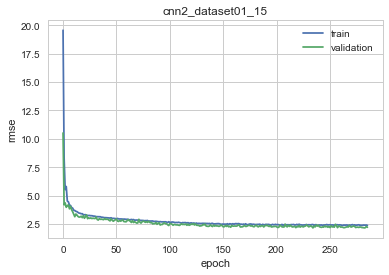

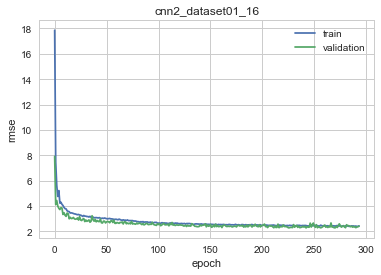

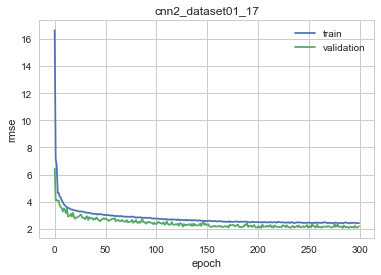

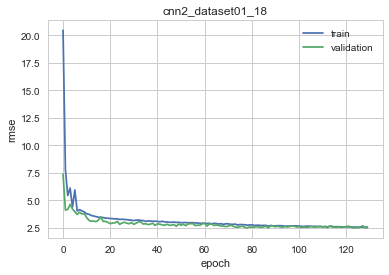

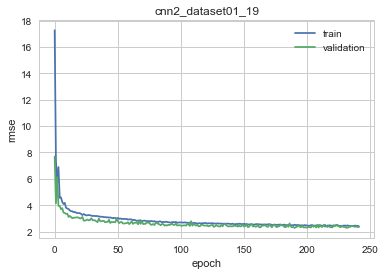

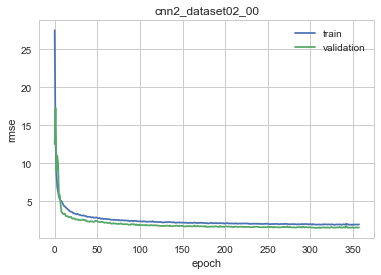

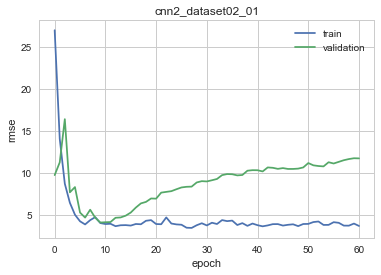

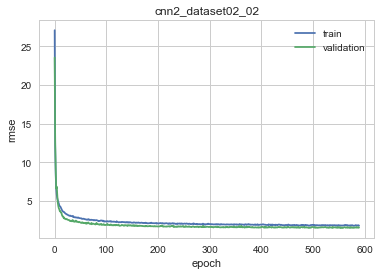

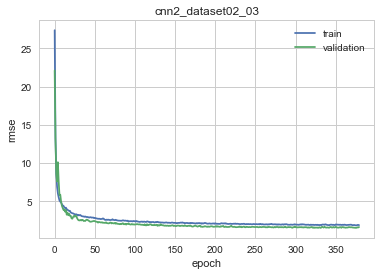

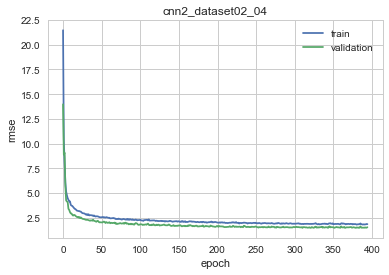

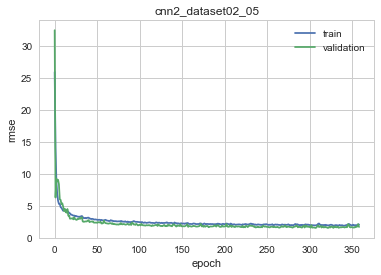

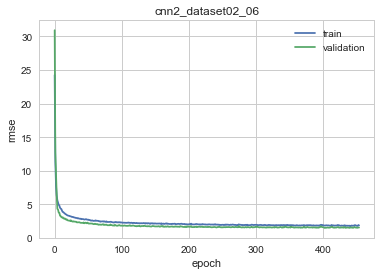

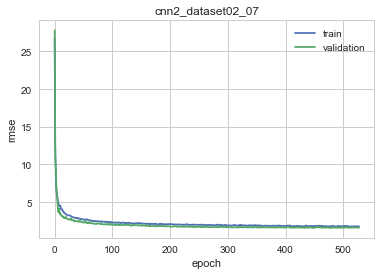

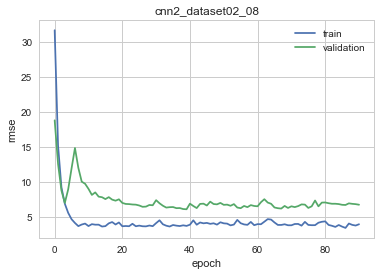

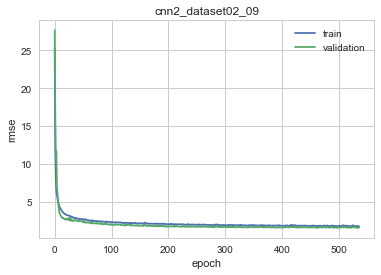

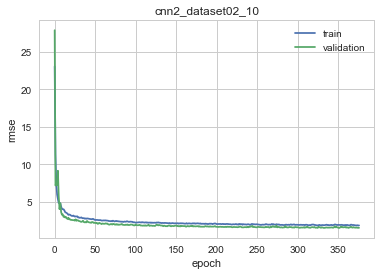

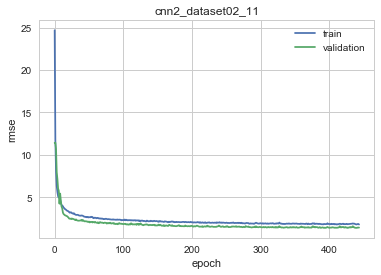

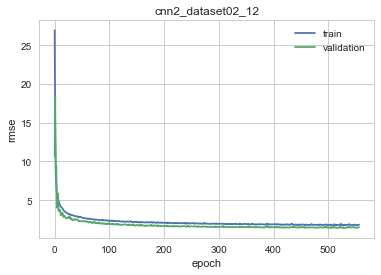

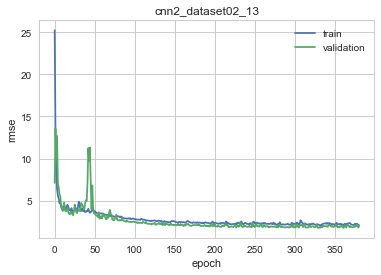

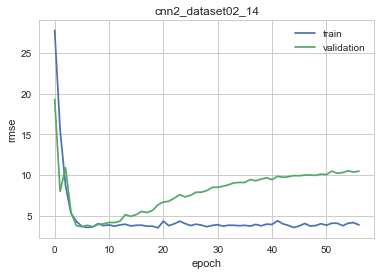

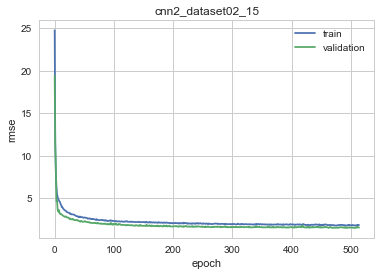

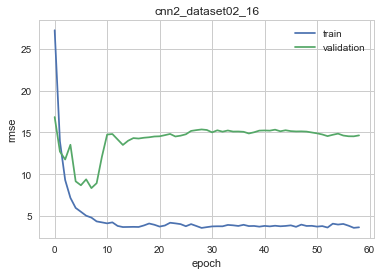

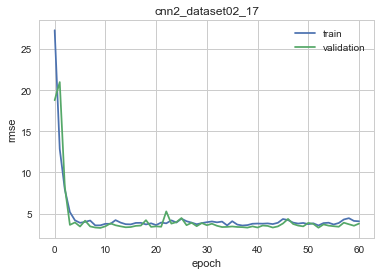

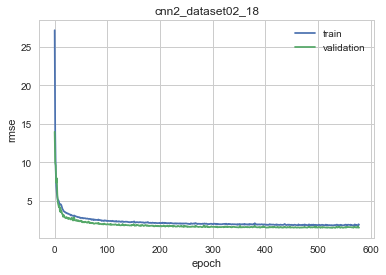

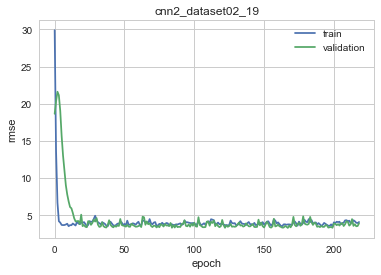

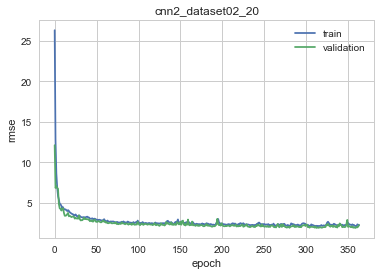

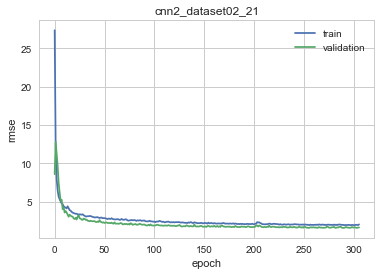

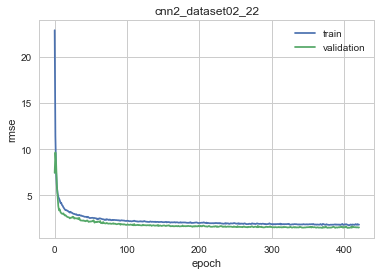

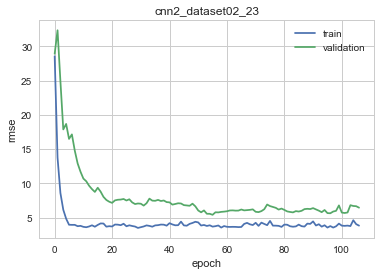

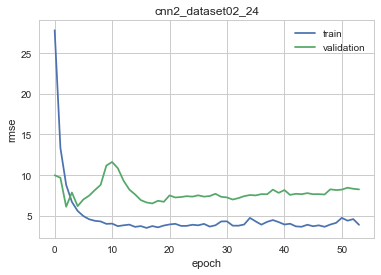

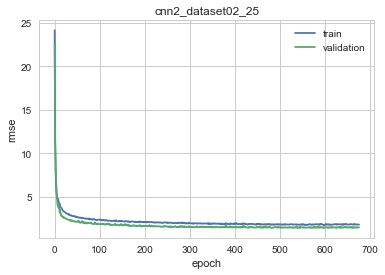

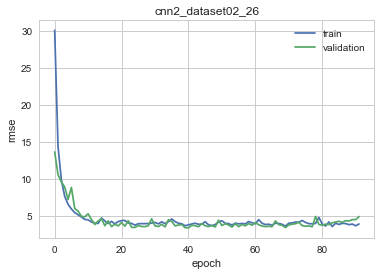

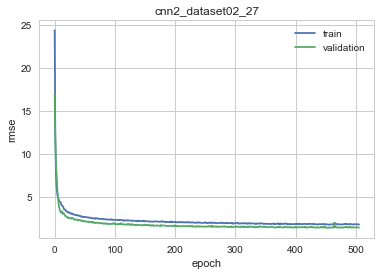

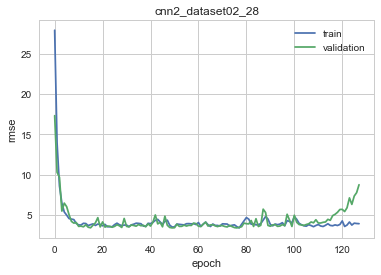

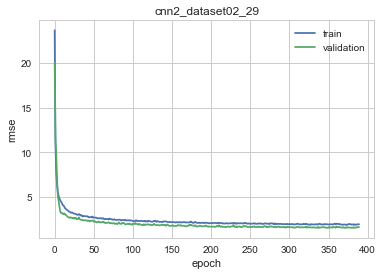

In [10]:
plot_loss_history(model_name, 'cnn2_dataset01', 20)
plot_loss_history(model_name, 'cnn2_dataset02', 30)

In [11]:
model = load_models_with_weights(model_name)

In [12]:
_ = predict_and_make_submission_file(X_test, model)

submission_20180324_0016.csv created for submission.


* Score (RMSE) of submission_20171120_0110.csv
  * public:  <strong>2.57497</strong>
  * private: <strong>2.52040</strong>

### Best CNN Model

In [13]:
best_cnns = pick_cnns(model, [4], [25])
_ = predict_and_make_submission_file(X_test, best_cnns)

submission_20180324_0016.csv created for submission.


* Score (RMSE) of submission_20171120_0116.csv
  * public:  <strong>2.25358</strong>
  * private: <strong>2.02075</strong>

The ensemble model shows worse performance. This is because the ensemble model includes overfitted CNNs with bad validation error as you can see above. Let's just select some of the good models and construct the ensemble again.

### Ensemble of CNNs with Good Performance

In [14]:
indexes08 = [0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19] 
indexes22 = [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 18, 21, 22, 25, 27, 29]
selected_ensemble = pick_cnns(model, indexes08, indexes22)
_ = predict_and_make_submission_file(X_test, selected_ensemble)

submission_20180324_0020.csv created for submission.


* Score (RMSE) of submission_20171120_0132.csv
  * public:  <strong>2.14311</strong>
  * private: <strong>1.92491</strong>

The ensemble model of well-trained CNNs shows better performance than the  single best model. It improved performance by approximately <strong>5%</strong>.

<a id="6.2"></a>
## Face Detection with OpenCV
  * For a better performance, let's detect a face with OpenCV2 and preditct the facial keypoints in it.

In [16]:
_ = predict_with_cv2_and_make_submission_file(X_test, selected_ensemble)

submission_20180324_0026.csv created for submission.


* score (RMSE): submission_20171120_1719.csv
  * public:  <strong>2.83592</strong>
  * private: <strong>2.51648</strong>
  
The performance got worse. This is because of frequent false positives. Let's see a prediction with OpenCV below.

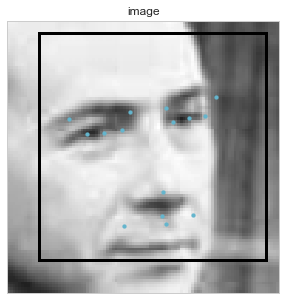

In [22]:
plot_keypoints_with_cv2(X_test[1137], selected_ensemble)

Since images are not clear profile pictures, there are many cases where OpenCV can not capture the exact position of the face. I decided not to use OpenCV2.

<a id="6.3"></a>
## Advanced Image Augmentation

In order to further optimize the model, I decided to apply data augmentation more variously.

  * Elastic Transformation
    * It moves each pixel individually around based on distortion fields.
  * Perspective Transformation
    * It transforms like viewing an object at another point.

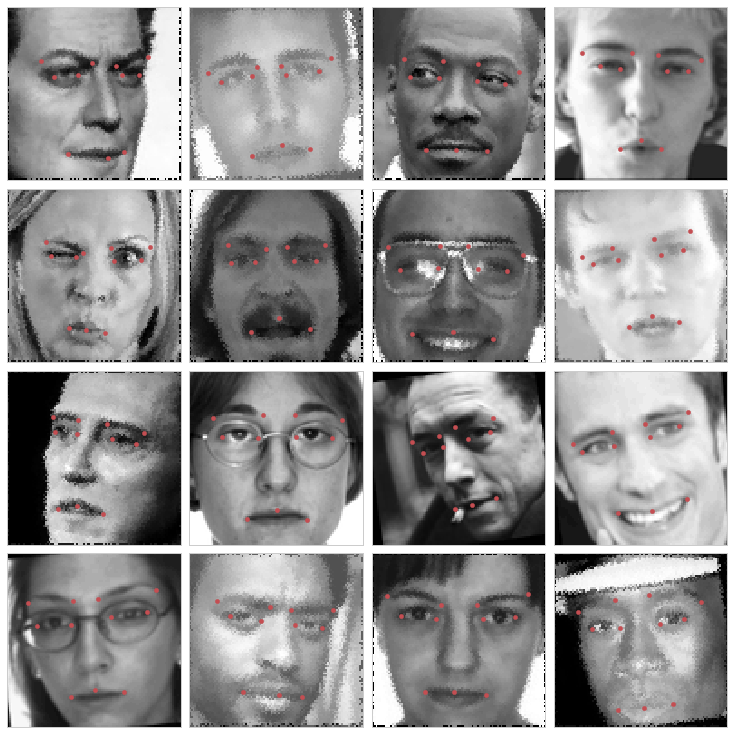

In [17]:
generate_augmented_images(X_train, Y_train, True, True, True, True, True)

In [18]:
final_model_name = 'final_model'
final_model = load_models_with_weights(final_model_name)

Let's train again with the advanced data augmentation and construct the ensemble model by selecting well-trained CNN models.

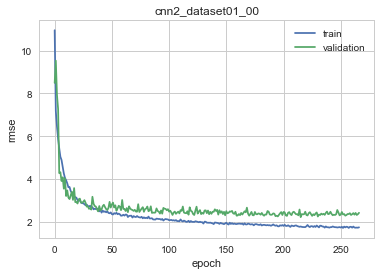

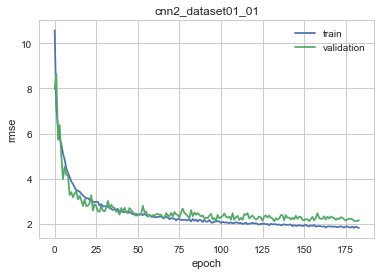

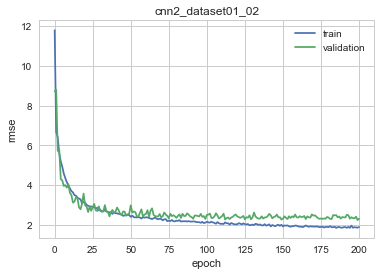

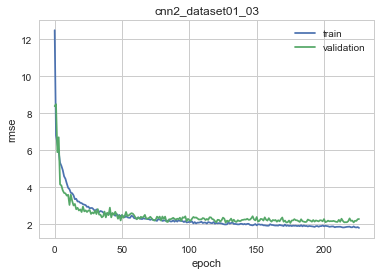

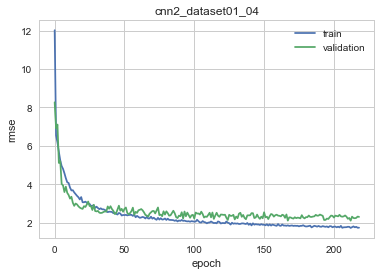

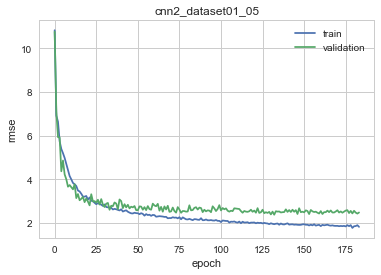

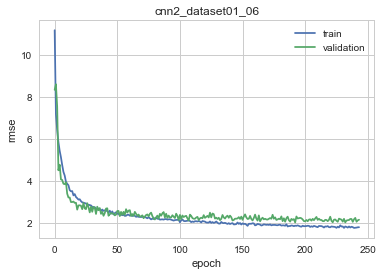

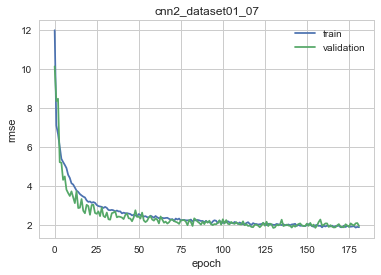

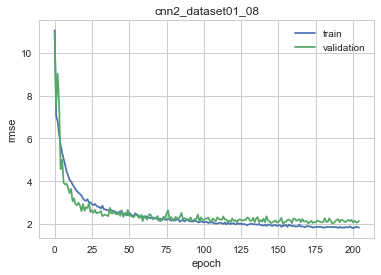

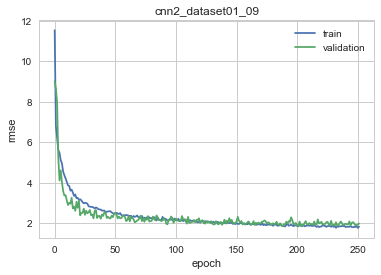

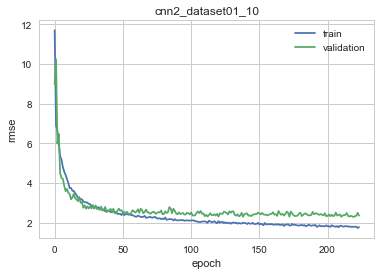

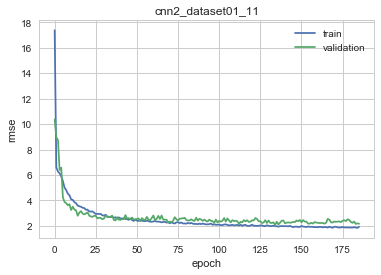

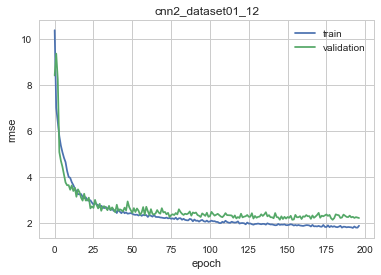

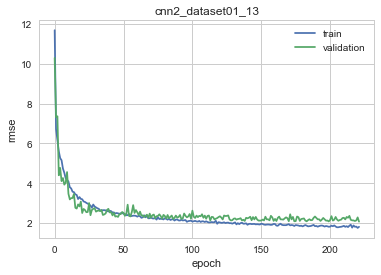

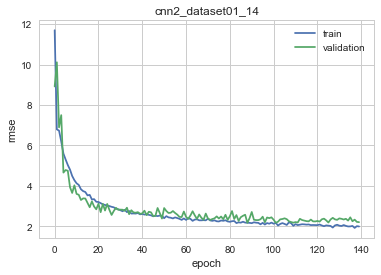

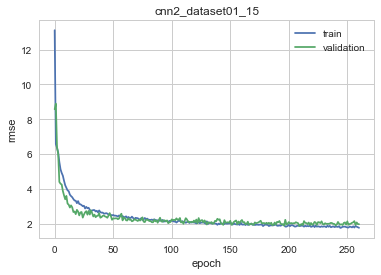

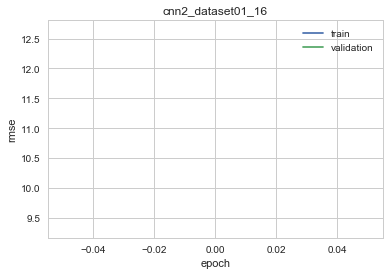

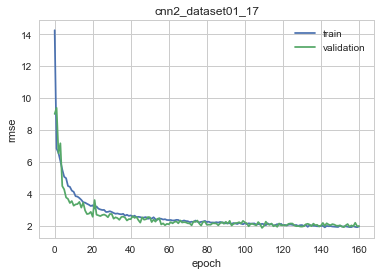

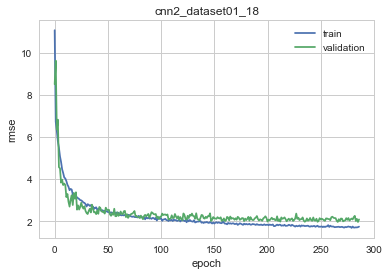

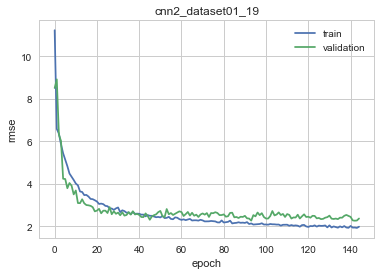

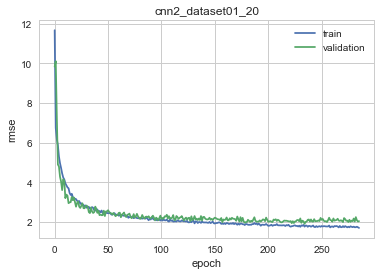

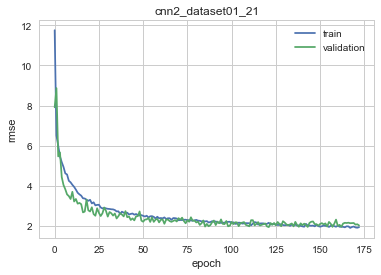

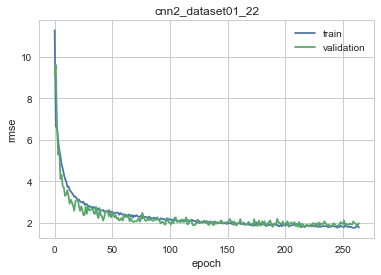

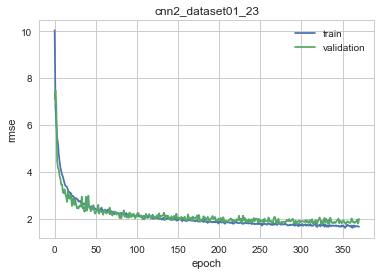

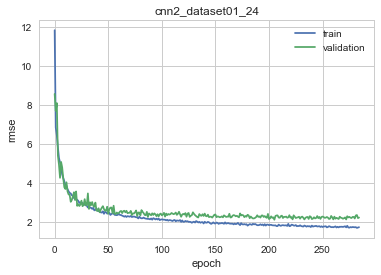

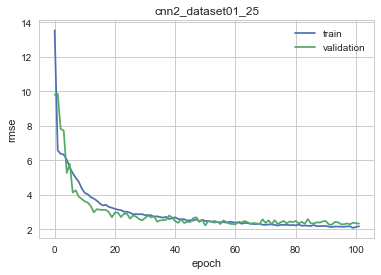

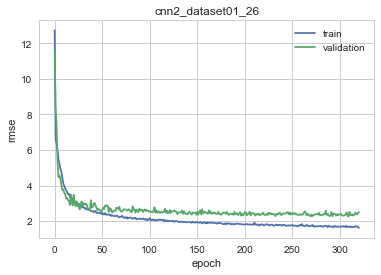

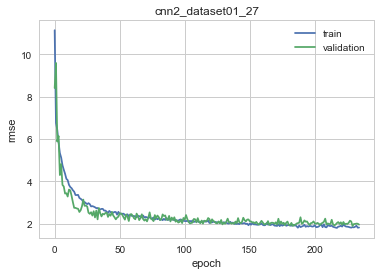

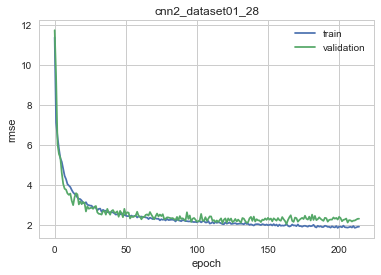

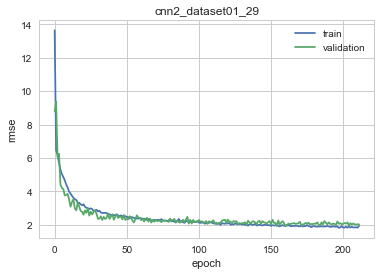

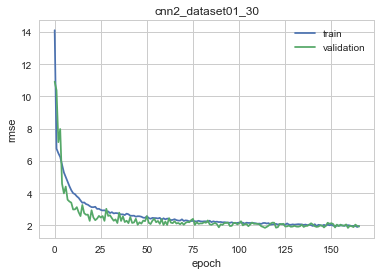

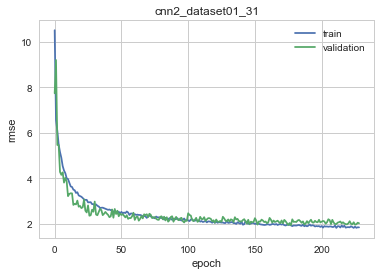

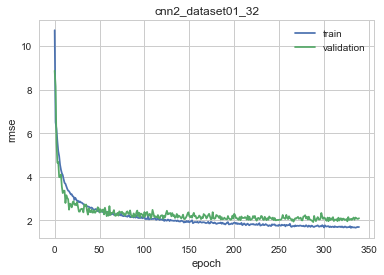

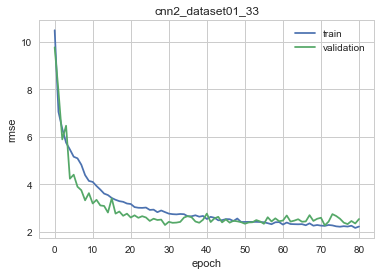

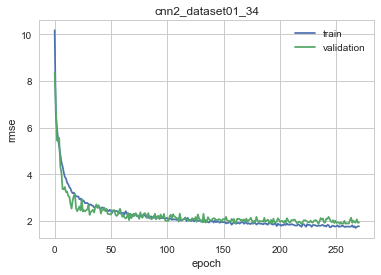

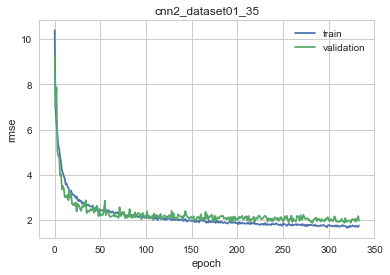

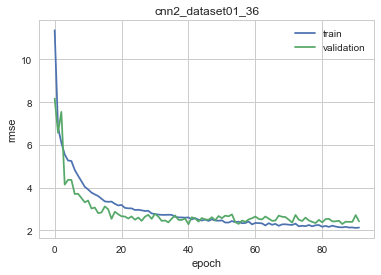

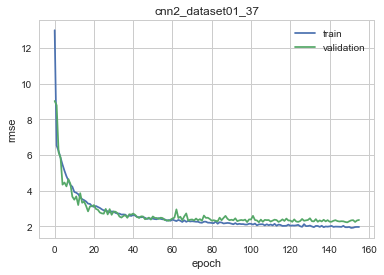

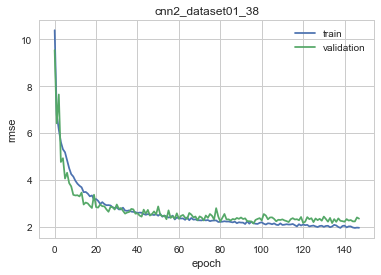

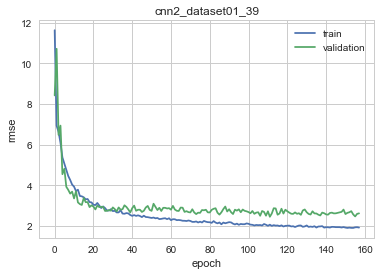

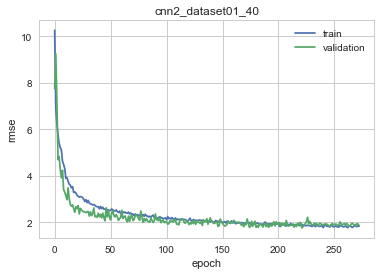

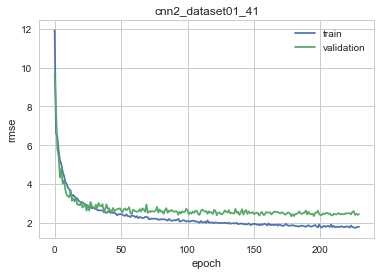

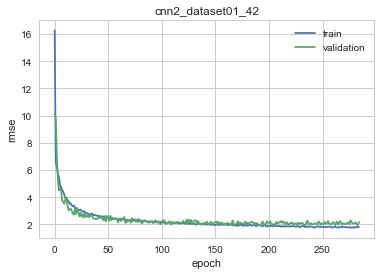

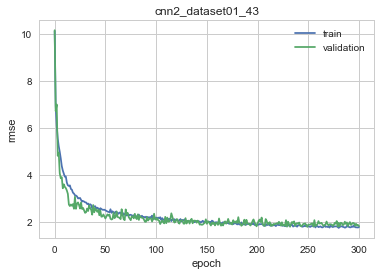

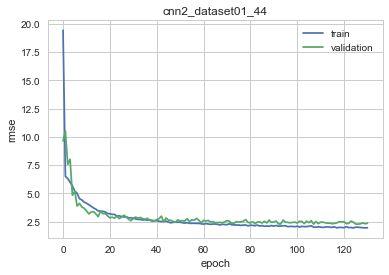

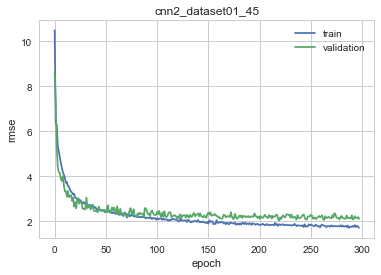

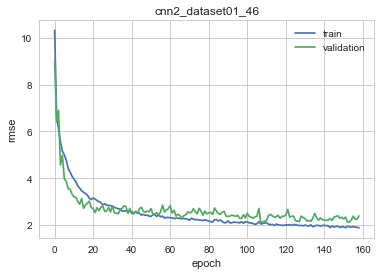

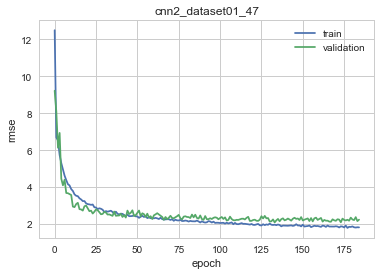

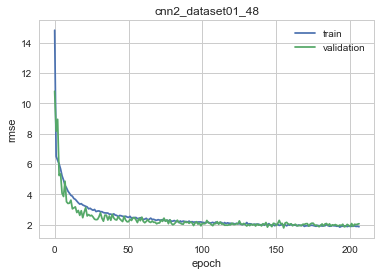

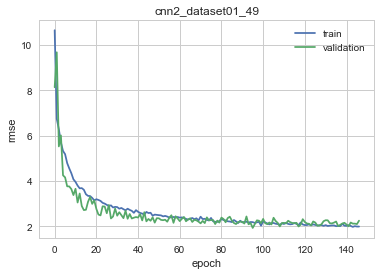

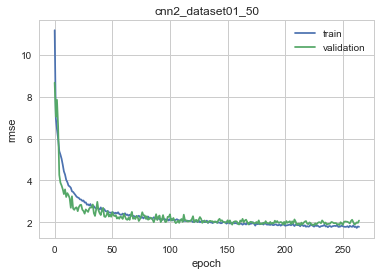

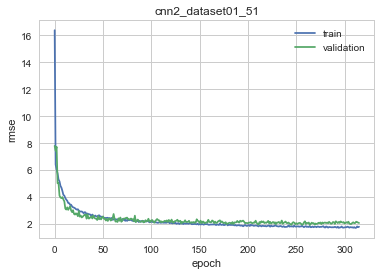

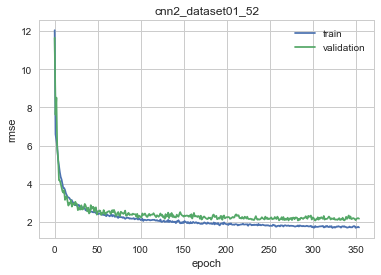

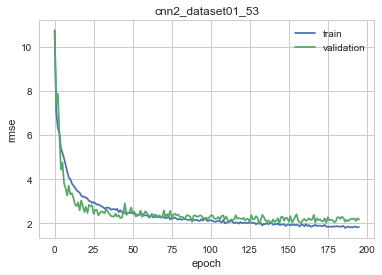

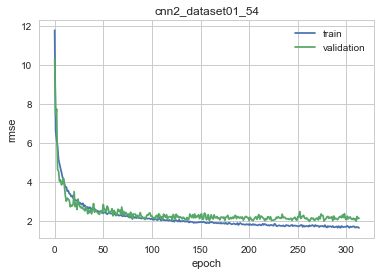

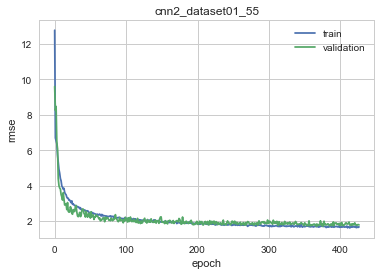

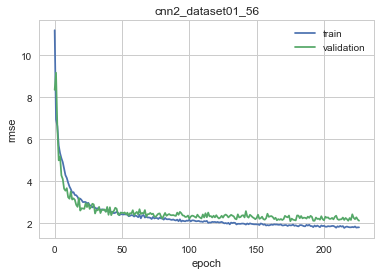

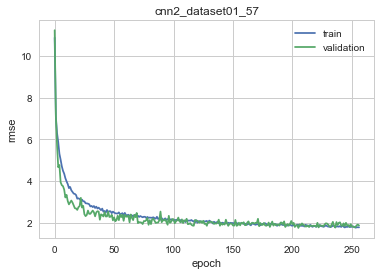

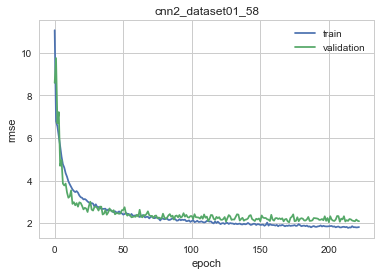

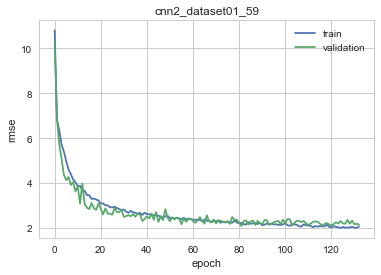

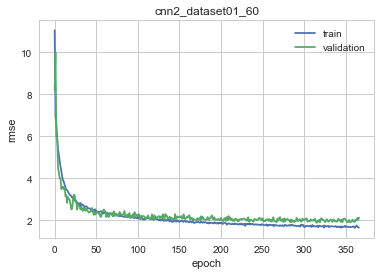

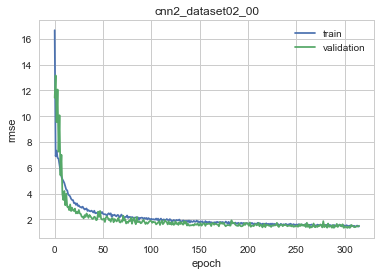

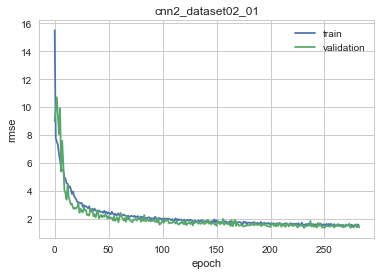

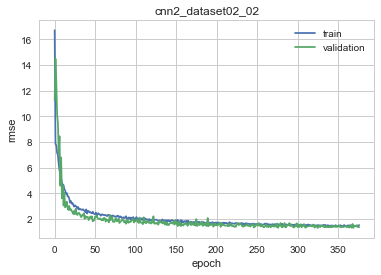

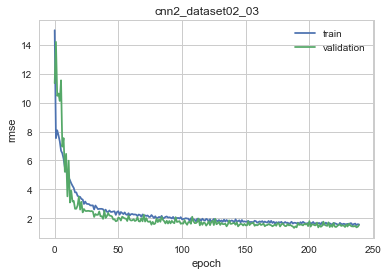

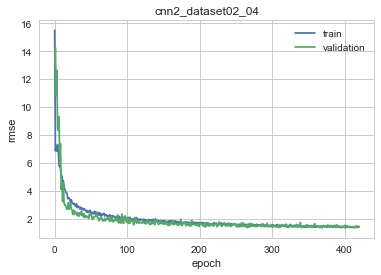

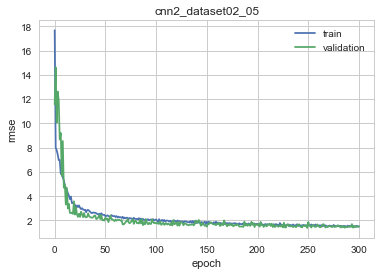

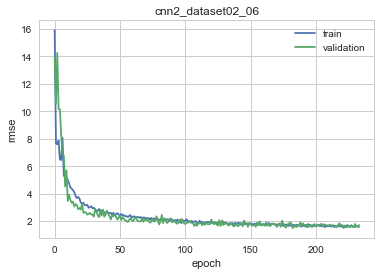

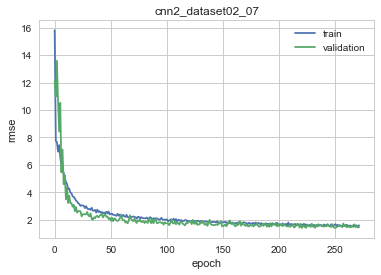

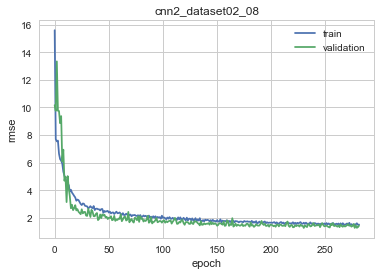

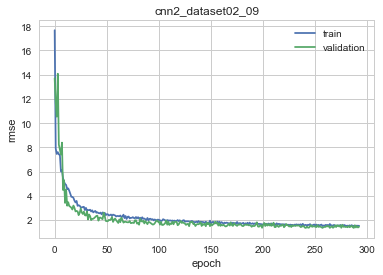

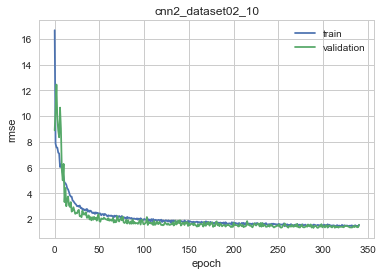

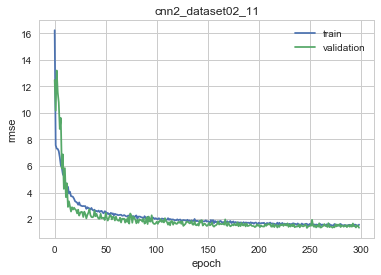

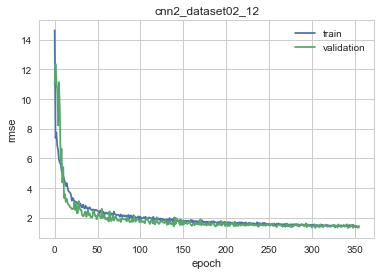

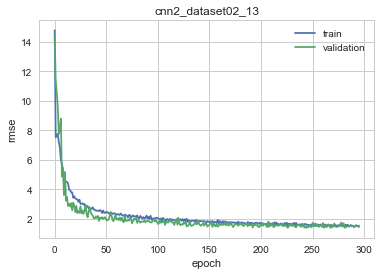

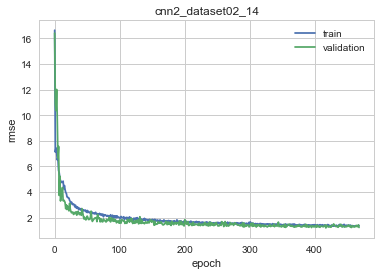

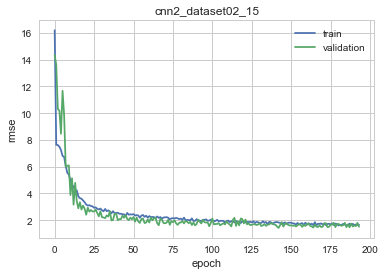

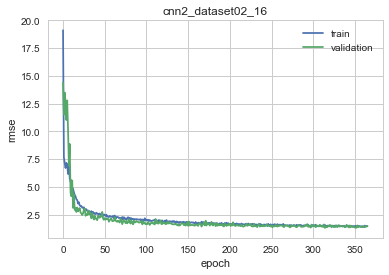

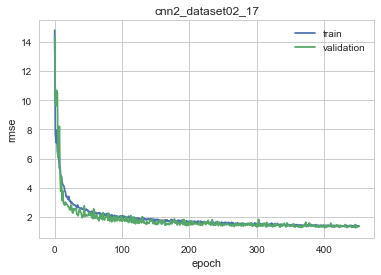

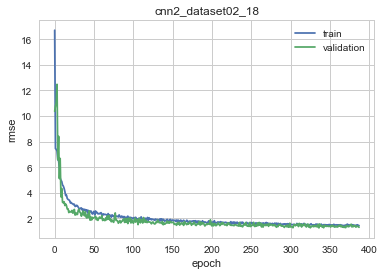

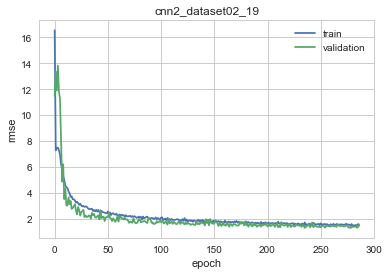

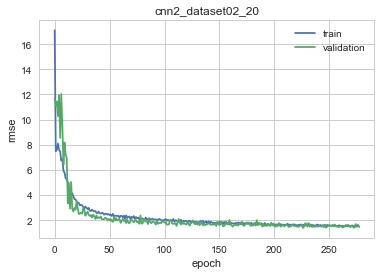

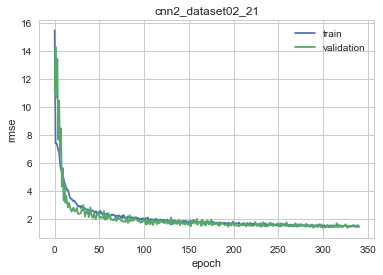

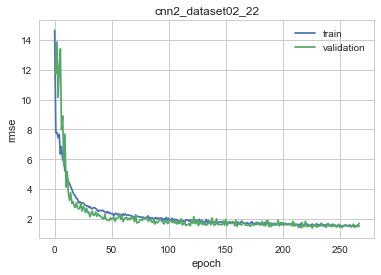

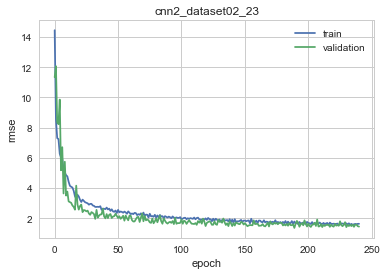

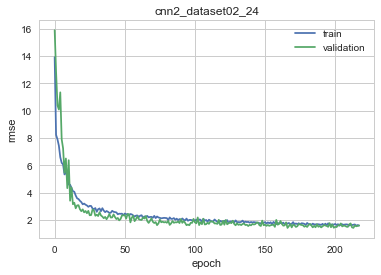

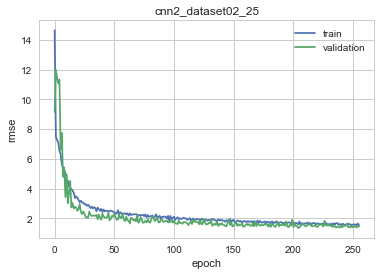

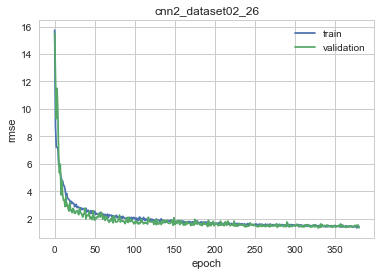

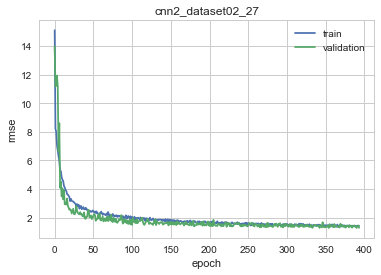

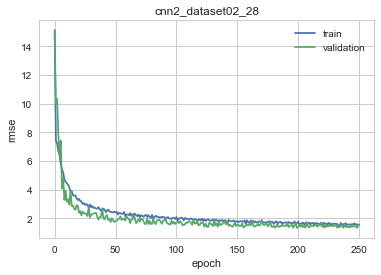

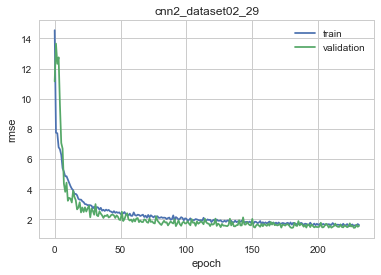

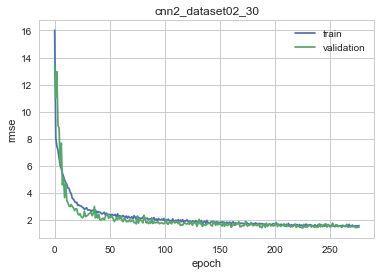

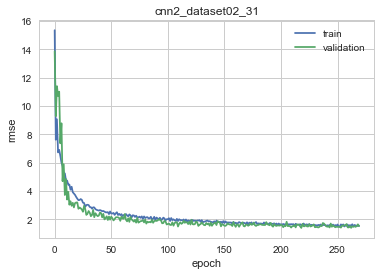

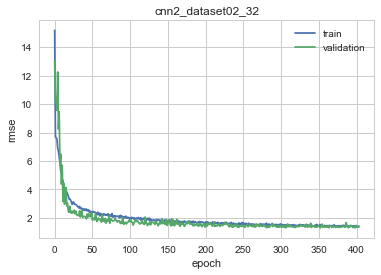

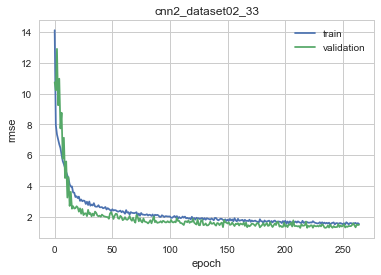

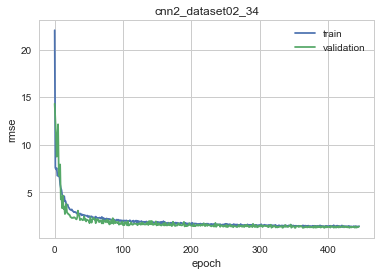

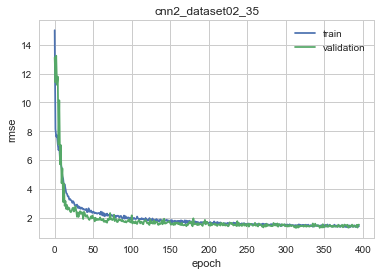

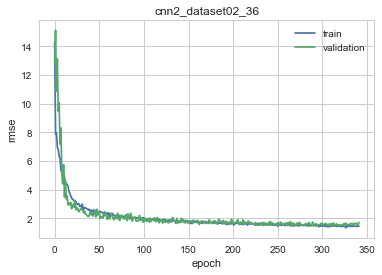

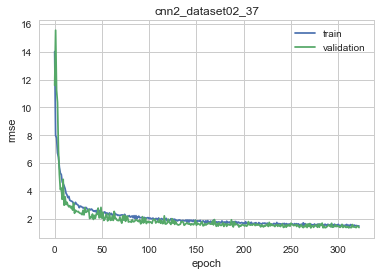

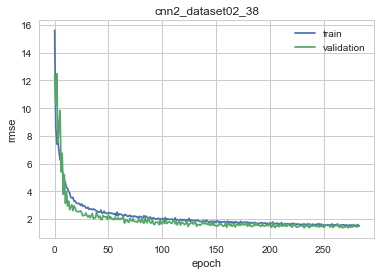

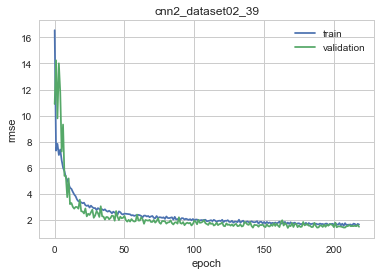

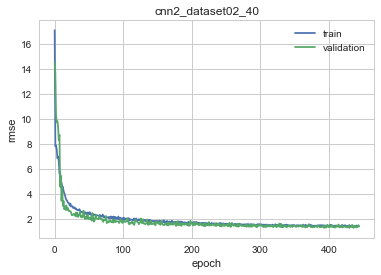

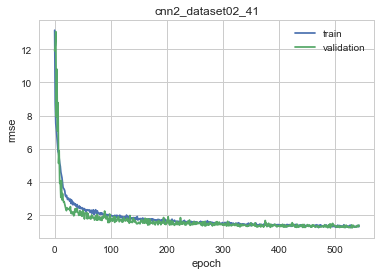

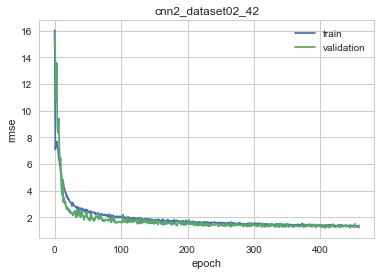

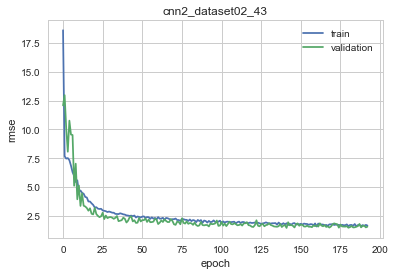

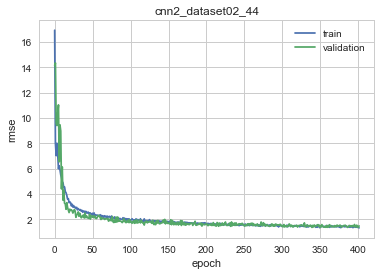

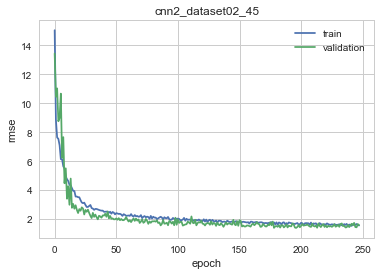

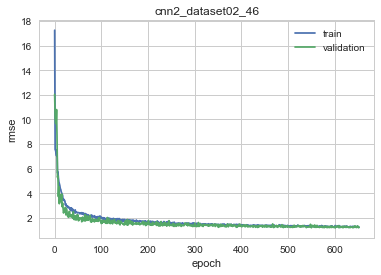

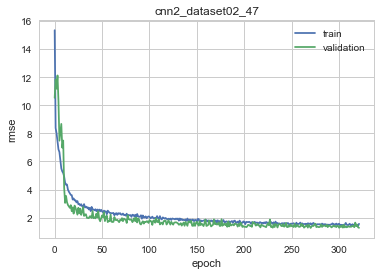

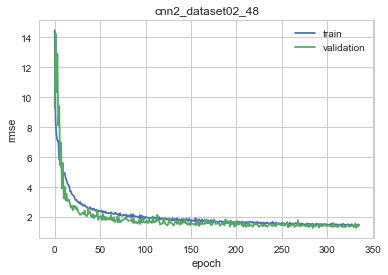

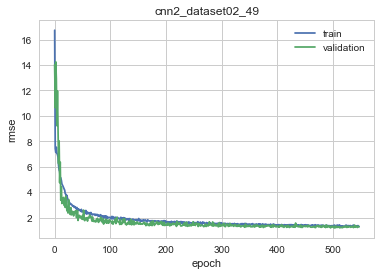

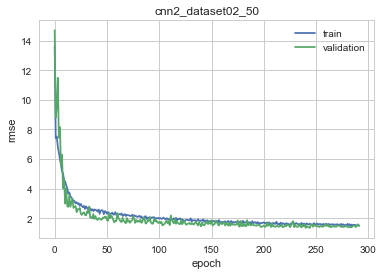

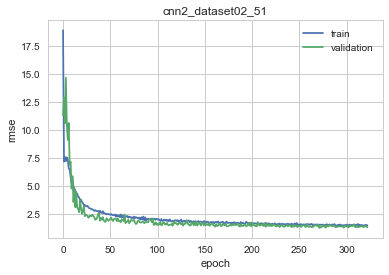

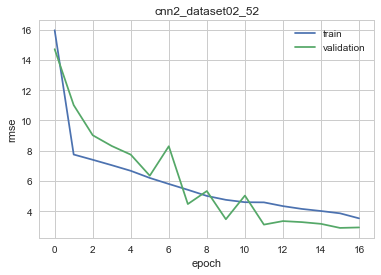

In [20]:
plot_loss_history(final_model_name, 'cnn2_dataset01', len(final_model[0]))
plot_loss_history(final_model_name, 'cnn2_dataset02', len(final_model[1]))

In [21]:
final_indexes08 = [7, 9, 15, 17, 22, 23, 27, 30, 40, 43, 55, 57] 
final_indexes22 = [0, 1, 2, 4, 8, 14, 17, 26, 27, 32, 34, 40, 41, 42, 46, 49]
final_selected_ensemble = pick_cnns(final_model, final_indexes08, final_indexes22)
_ = predict_and_make_submission_file(X_test, final_selected_ensemble)

submission_20180324_0034.csv created for submission.


<a id="7"></a>
# 7. Final Kaggle Submission
<a id="7.1"></a>
## Final Score
* score (RMSE): submission_20171122_0152.csv
  * public:  <strong>1.87261</strong>
  * private: <strong>1.64578</strong>

My final score is about sixth and seventh out of the 175 participating teams according to the public and private learderboards, respectively.
<br><br>
The additional data augmentation techniques improved the performance by <strong>14.5%</strong>. This shows that more and more data is good for performance improvement.
<br>
<br>
One thing that impressed me was that there was no single overfitted CNN model out of 110 trained models even though I did not apply any normalization. This is because training-time data augmentation has allowed the model to be trained with almost infinite data.

<img src="img/finalscore.png" />

### Private Leaderboard
<img src="img/private.png" />

### Public Leaderboard
<img src="img/public.png" />